In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os

## preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE

## models
from sklearn.ensemble import RandomForestClassifier
from pycaret.classification import *
from sklearn.ensemble import ExtraTreesClassifier
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

In [237]:
# pip install --pre mlflow ## This installs the latest and greatest mlflow package

In [199]:
df = pd.read_csv('Churn_Modeling.csv')

In [201]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### EDA

In [203]:
#These are functions to create nice graphs
import plotly.express as px

def plot_churn_by_categorical_features(df, target_col='Exited'):
    # This excludes floats and ints
    categorical_cols = df.select_dtypes(exclude=['number']).columns
    categorical_cols = [col for col in categorical_cols if col != target_col]

    for col in categorical_cols:
        fig = px.histogram(
            df,
            x=target_col,
            color=col,
            barmode="group",
            title=f"<b>Churn by {col}</b>"
        )
        fig.update_layout(width=700, height=500, bargap=0.1)
        fig.show()
        
def plot_categorical_distributions(df):
    # Select all non-numeric columns
    categorical_cols = df.select_dtypes(exclude=['number']).columns

    for col in categorical_cols:
        fig = px.histogram(
            df,
            x=col,
            color=col,
            title=f"<b>Distribution of {col}</b>",
            barmode="group"
        )
        fig.update_layout(width=700, height=500, bargap=0.1)
        fig.show()

In [205]:
#Get Data Shape
df.shape

(10000, 14)

In [207]:
#Columns
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [209]:
#Get info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [211]:
#Let's get ranges of values and break down of them
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [213]:
#Check how many unique values each columns has
df.nunique(axis=0)

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

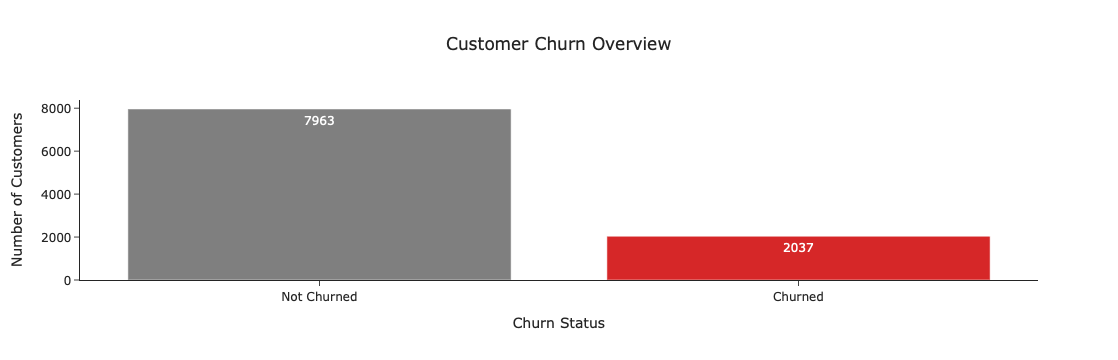

In [225]:
# Count of Exited values
churn_counts = df['Exited'].value_counts().reset_index()
churn_counts.columns = ['Exited', 'Count']
churn_counts['Status'] = churn_counts['Exited'].map({0: 'Not Churned', 1: 'Churned'})

# Color map: red for churned, grey for not churned
color_map = {'Churned': '#d62728', 'Not Churned': '#7f7f7f'}  # Red and grey

# Create bar chart
fig = px.bar(
    churn_counts,
    x='Status',
    y='Count',
    title='Customer Churn Overview',
    labels={'Count': 'Number of Customers', 'Status': 'Churn Status'},
    text='Count',
    color='Status',
    color_discrete_map=color_map,
    width = 700
)

fig.update_layout(
    title_x=0.5,
    template='simple_white',
    showlegend=False
)

fig.show()

In [47]:
#Let's check the unique geography locations
df.Geography.value_counts()
# df.Geography.value_counts(normalize=True)

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [49]:
#Let's check the unique values of male and gemale
df.Gender.value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

In [51]:
#Let's check the breakdown of churn as proportion can impact the model performance
df.Exited.value_counts() 

Exited
0    7963
1    2037
Name: count, dtype: int64

In [53]:
#Let's check credit scores by geography and gender
df.groupby(['Geography','Gender'])['CreditScore'].mean()

Geography  Gender
France     Female    649.185759
           Male      650.064657
Germany    Female    653.093881
           Male      649.966565
Spain      Female    651.769513
           Male      650.992075
Name: CreditScore, dtype: float64

In [55]:
#Let's check exited by male and female
df.groupby(['Gender'])['Exited'].value_counts(normalize=True)

Gender  Exited
Female  0         0.749285
        1         0.250715
Male    0         0.835441
        1         0.164559
Name: proportion, dtype: float64

In [57]:
#Let's check exited by location
df.groupby(['Geography'])['Exited'].value_counts(normalize=True)

Geography  Exited
France     0         0.838452
           1         0.161548
Germany    0         0.675568
           1         0.324432
Spain      0         0.833266
           1         0.166734
Name: proportion, dtype: float64

In [59]:
#Let's check by product
df.groupby(['NumOfProducts'])['Exited'].value_counts(normalize=True)

NumOfProducts  Exited
1              0         0.722856
               1         0.277144
2              0         0.924183
               1         0.075817
3              1         0.827068
               0         0.172932
4              1         1.000000
Name: proportion, dtype: float64

In [61]:
#Let's check by how active someone is
df.groupby(['IsActiveMember'])['Exited'].value_counts(normalize=True)

IsActiveMember  Exited
0               0         0.731491
                1         0.268509
1               0         0.857309
                1         0.142691
Name: proportion, dtype: float64

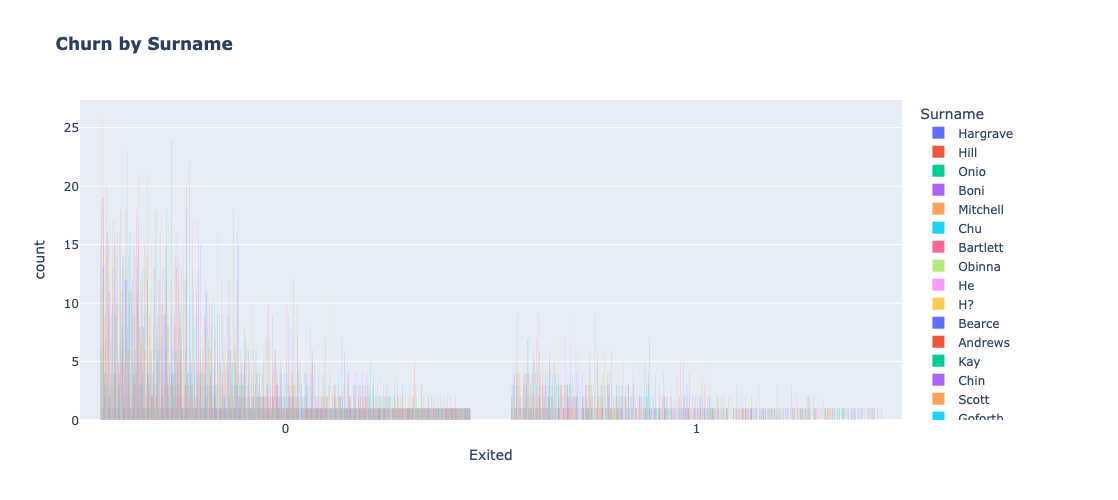

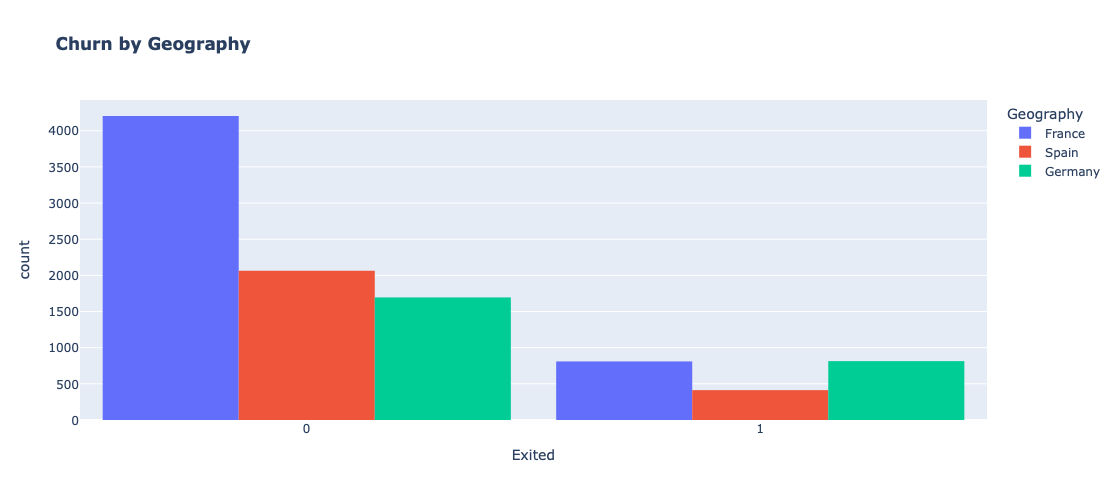

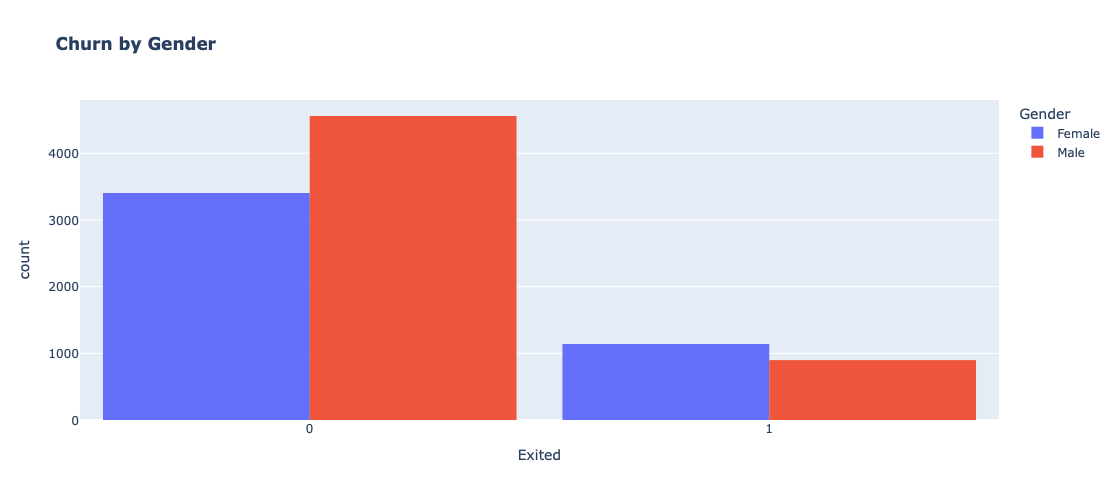

In [63]:
plot_churn_by_categorical_features(df, target_col='Exited')

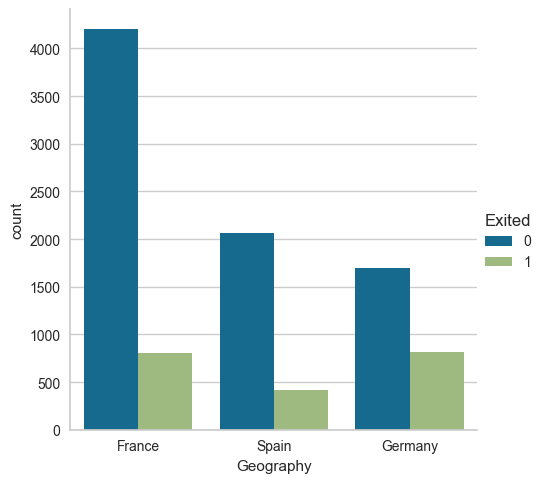

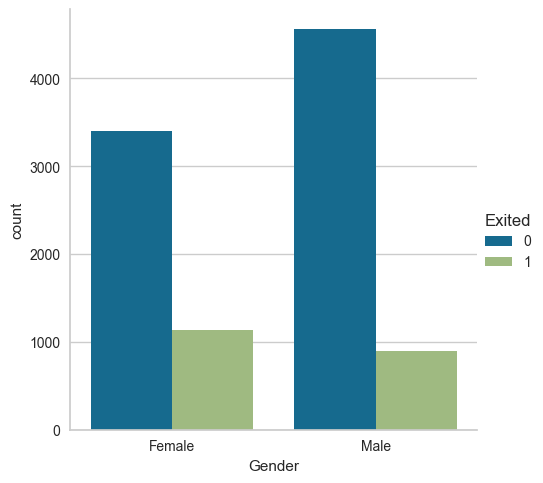

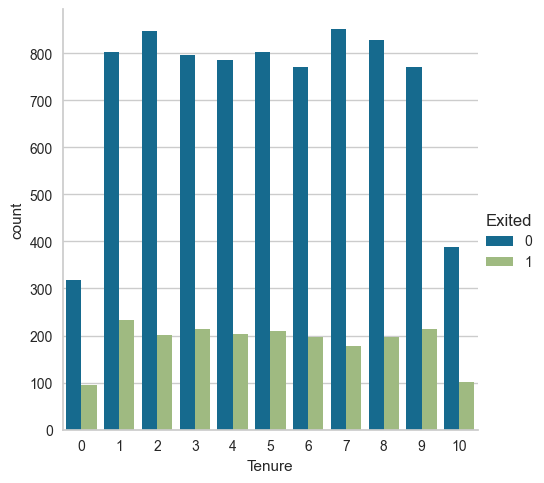

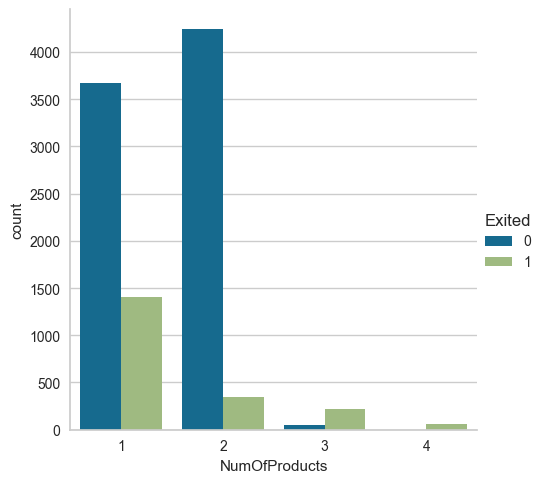

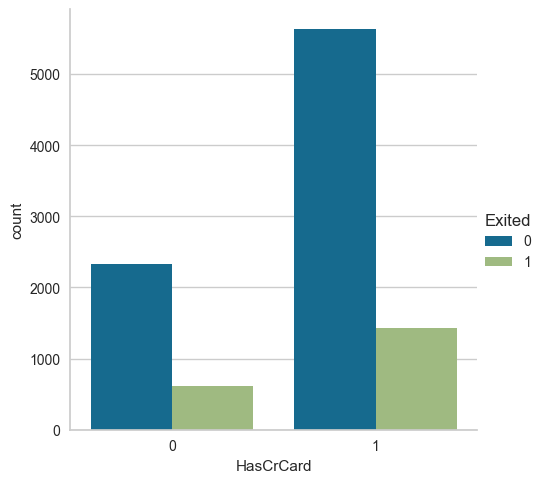

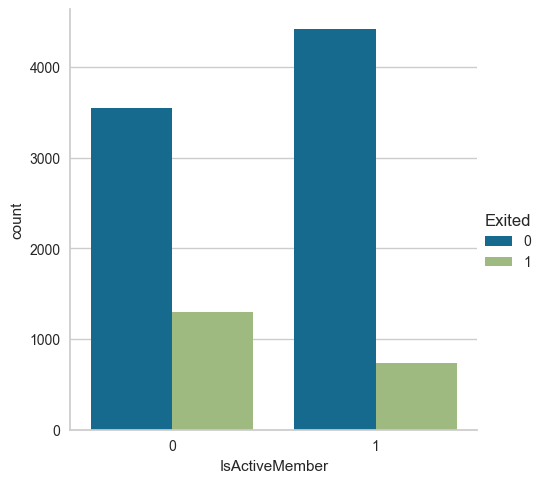

In [227]:
#Let's view exited across features

sns.catplot(x='Geography', hue = 'Exited', data = churn_df, kind="count")
sns.catplot(x='Gender', hue = 'Exited', data = churn_df, kind="count")
sns.catplot(x='Tenure', hue = 'Exited', data = churn_df, kind="count")
sns.catplot(x='NumOfProducts', hue = 'Exited', data = churn_df, kind="count")
sns.catplot(x='HasCrCard', hue = 'Exited', data = churn_df, kind="count")
sns.catplot(x='IsActiveMember', hue = 'Exited', data = churn_df, kind="count")

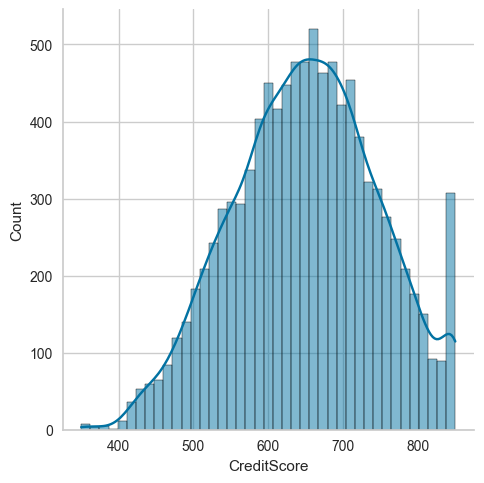

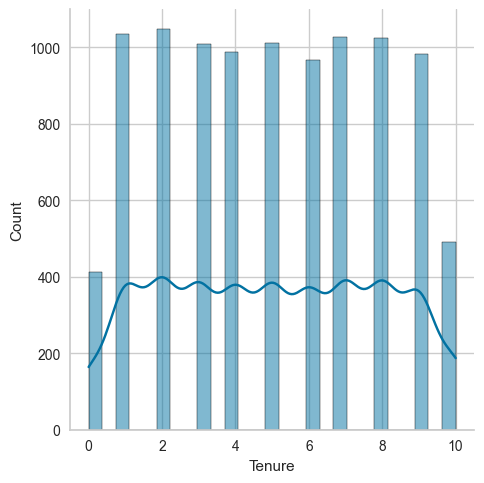

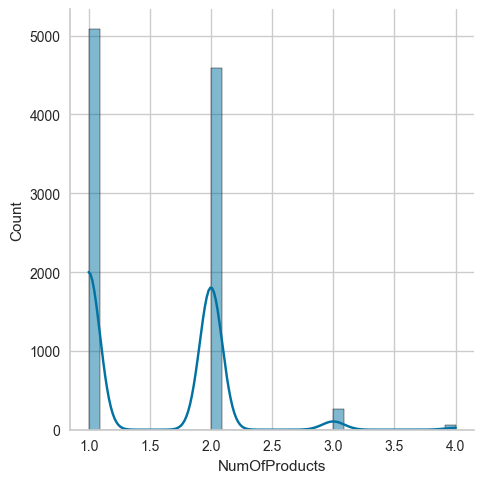

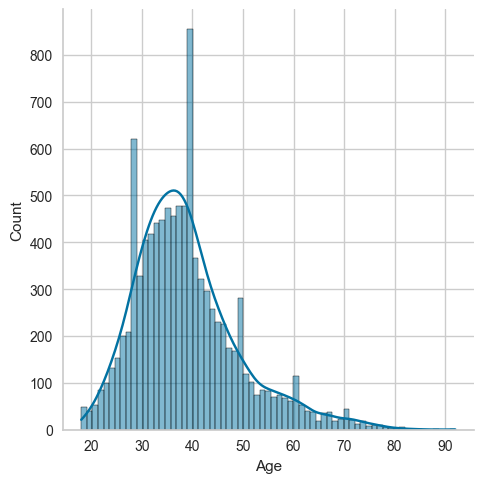

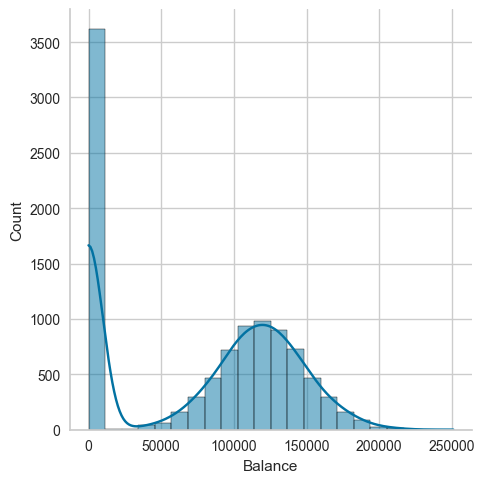

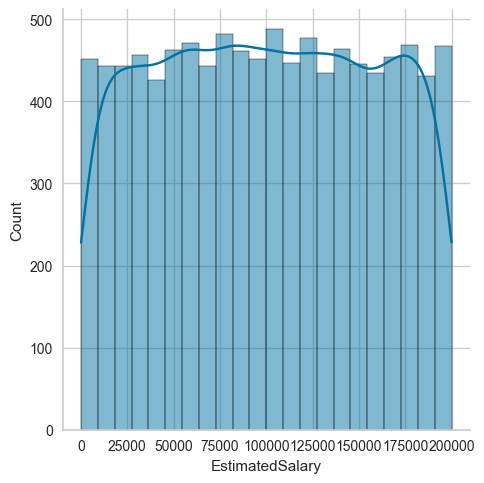

In [229]:
#Let's check histograms for normality assumptions
sns.displot(churn_df, x='CreditScore', kind="hist", kde = True)
sns.displot(churn_df, x='Tenure', kind="hist", kde = True)
sns.displot(churn_df, x='NumOfProducts', kind="hist", kde = True)
sns.displot(churn_df, x='Age', kind="hist", kde = True)
sns.displot(churn_df, x='Balance', kind="hist", kde = True)
sns.displot(churn_df, x='EstimatedSalary', kind="hist", kde = True)

### Data Pre-processing

In this code I drop columns that are not needing for modeling and use label encoding on categorical values. 

In [253]:
#Drop unneded columns
churn_df = df.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)

In [255]:
# #Perform one-hot encoding

# categorical_cols = churn_df.select_dtypes(include=['object','category']).columns.tolist()
# churn_encoded = pd.get_dummies(churn_df, columns = categorical_cols, drop_first = True)
# # categorical_cols



# ###OR Label Encoding
churn_df['Geography']=churn_df['Geography'].map({'France':1,'Spain':2,'Germany':3})
churn_df ['Gender']=churn_df['Gender'].map({'Female':1,'Male':2})

### Model Training

In [257]:
#Prepare data for modeling
X = churn_df.drop('Exited', axis = 1)
y = churn_df['Exited']

In [259]:
#Use SMOTE
smote = SMOTE()
X, y = smote.fit_resample(X, y)

churn_data_new = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1)
churn_data_new

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,1,1,42,2,0.000000,1,1,1,101348.880000,1
1,608,2,1,41,1,83807.860000,1,0,1,112542.580000,0
2,502,1,1,42,8,159660.800000,3,1,0,113931.570000,1
3,699,1,1,39,1,0.000000,2,0,0,93826.630000,0
4,850,2,1,43,2,125510.820000,1,1,1,79084.100000,0
...,...,...,...,...,...,...,...,...,...,...,...
15921,743,2,1,37,2,0.000000,1,1,0,121837.182255,1
15922,671,1,1,51,7,187538.276021,1,1,0,185699.735030,1
15923,643,3,1,47,7,88769.013259,1,1,0,119308.130109,1
15924,623,1,1,46,3,0.000000,1,1,0,161319.869105,1


In [261]:
#Run Pycaret to check different model performance
classification_setup = setup(data= churn_data_new, target='Exited',
                             remove_outliers=True,normalize=True,
                             normalize_method='robust', 
                             session_id = 6563, 
                             pca = True, 
                             pca_method = 'linear')

,Description,Value
0,Session id,6563
1,Target,Exited
2,Target type,Binary
3,Original data shape,"(15926, 11)"
4,Transformed data shape,"(15368, 11)"
5,Transformed train set shape,"(10590, 11)"
6,Transformed test set shape,"(4778, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


In [263]:
compare_models(exclude = ['lda'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8315,0.9146,0.8276,0.8343,0.8308,0.6631,0.6633,0.1150
rf,Random Forest Classifier,0.8302,0.9106,0.8202,0.8370,0.8284,0.6604,0.6607,0.3060
lightgbm,Light Gradient Boosting Machine,0.8268,0.9089,0.8159,0.8340,0.8248,0.6536,0.6539,0.3850
xgboost,Extreme Gradient Boosting,0.8230,0.9066,0.8208,0.8246,0.8226,0.6460,0.6462,0.0600
gbc,Gradient Boosting Classifier,0.8152,0.8979,0.8057,0.8214,0.8133,0.6304,0.6308,0.5210
knn,K Neighbors Classifier,0.8010,0.8732,0.8156,0.7925,0.8037,0.6019,0.6024,0.0510
ada,Ada Boost Classifier,0.7889,0.8694,0.7919,0.7873,0.7894,0.5779,0.5781,0.1450
qda,Quadratic Discriminant Analysis,0.7888,0.8704,0.7641,0.8041,0.7832,0.5777,0.5788,0.0380
nb,Naive Bayes,0.7770,0.8541,0.7436,0.7968,0.7692,0.5540,0.5554,0.0380
lr,Logistic Regression,0.7724,0.8475,0.7741,0.7717,0.7727,0.5448,0.5451,0.0420


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=6563, verbose=0,
                     warm_start=False)

### Feature Importance

In [268]:
# Create a DataFrame of feature importances
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Display top 10
print(feature_importances.head(10))

           feature  importance
3              Age    0.225534
9  EstimatedSalary    0.128596
5          Balance    0.122594
0      CreditScore    0.117590
8   IsActiveMember    0.112311
6    NumOfProducts    0.095309
2           Gender    0.073539
4           Tenure    0.073011
1        Geography    0.031247
7        HasCrCard    0.020269


### Model for production

In [ ]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080") #This sets tracking to our local console

In [268]:
import mlflow
from mlflow.models import infer_signature

# Create a new MLflow Experiment
mlflow.set_experiment("May 2025 Churn Prediction Model")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log important metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("auc", auc)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Basic Random Forrest model for Churn Prediction")

    # Infer the model signature
    signature = infer_signature(X_train, rf.predict(X_train))

    # Log the RandomForestClassifier model
    model_info = mlflow.sklearn.log_model(
        # registered_model_name = 
        sk_model=rf,
        artifact_path="random_forest_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="random-forest-classifier"
    )

Successfully registered model 'random-forest-classifier'.
2025/05/22 16:42:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: random-forest-classifier, version 1


🏃 View run judicious-pig-635 at: http://127.0.0.1:8080/#/experiments/552496055272369617/runs/0f2125ad6dd1486bbf882d9f2aaa48f1
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/552496055272369617


Created version '1' of model 'random-forest-classifier'.


In [243]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import pandas as pd

def train_random_forest(df, use_smote=True, use_standardize=False, encoding_method='one-hot'):
    # Step 1: Encoding
    if encoding_method == 'one-hot':
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
        df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    elif encoding_method == 'label':
        df_encoded = df.copy()
        if 'Geography' in df_encoded.columns:
            df_encoded['Geography'] = df_encoded['Geography'].map({'France': 1, 'Spain': 2, 'Germany': 3})
        if 'Gender' in df_encoded.columns:
            df_encoded['Gender'] = df_encoded['Gender'].map({'Female': 1, 'Male': 2})
    else:
        raise ValueError("encoding_method must be 'one-hot' or 'label'")

    # Step 2: Feature/target split
    X = df_encoded.drop('Exited', axis=1)
    y = df_encoded['Exited']

    # Step 3: SMOTE
    if use_smote:
        smote = SMOTE()
        X, y = smote.fit_resample(X, y)

    # Step 4: Train/test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Step 5: Standardize if requested (not needed for RF, but added for experimentation)
    if use_standardize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Step 6: Train Random Forest
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        class_weight='balanced'
    )
    rf.fit(X_train, y_train)

    # Step 7: Evaluate
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]  # For AUC

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob)
    }

    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    return rf, metrics


### Model with SMOTE, no Standardization and One-Hot Encoding [Selected Model]

In [271]:
# Train with SMOTE, no standardization, one-hot encoding
rf_model, metrics = train_random_forest(df, use_smote=True, use_standardize=False, encoding_method='one-hot')

Accuracy: 0.8966
Precision: 0.9158
Recall: 0.8736
F1 Score: 0.8942
AUC: 0.9615


### Model with SMOTE, Standardization and One-Hot Encoding

In [288]:
# Train with SMOTE, standardization, one-hot encoding
rf_model, metrics = train_random_forest(df, use_smote=True, use_standardize=True, encoding_method='one-hot')

Accuracy: 0.8966
Precision: 0.9224
Recall: 0.8661
F1 Score: 0.8934
AUC: 0.9608


### Model without SMOTE, Standardization and One-Hot Encoding

In [290]:
# Train without SMOTE, no standardization, one-hot encoding
rf_model, metrics = train_random_forest(df, use_smote=False, use_standardize=False, encoding_method='one-hot')

Accuracy: 0.8517
Precision: 0.8517
Recall: 0.3290
F1 Score: 0.4746
AUC: 0.8531
